# libraries imported

In [1]:
import os
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import CategoricalAccuracy
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report, roc_curve, auc, confusion_matrix


In [2]:
#  It checks if your system has any GPUs that can be used for deep learning tasks.
print(tf.config.experimental.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Nov  2 16:01:55 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#EDA - Training set

In [4]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
# Create 'label' column
#defining base path
base_path = "/content/drive/My Drive/Project/MURA-v1.1"
#construct the file path to the CSV file named "train_image_paths.csv" by joining the base_path and the CSV file's name using the os.path.join
image_csv_path = os.path.join(base_path, "train_image_paths.csv")
#will read the above csv file and save in the data frame with column name paths
images_df = pd.read_csv(image_csv_path, names=['paths'])
#create complete file paths for each X-ray image.
images_df["paths"] = "/content/drive/My Drive/Project/" + images_df["paths"]
#create new column label in the dataframe  will indicate +ve or -ve
# If a path contains the word 'positive,' it is assigned a label of 1 (abnormal), and if not, it's assigned a label of 0 (normal).
images_df['label'] = images_df['paths'].str.contains('positive').astype(int)
# It extracts the seventh element (index 7) of each path after splitting the path using '/'
images_df['body_part'] = images_df['paths'].str.split('/').str[7]
#  'label' column was initially created as integers (0 or 1), it is now converted to strings.
images_df['label'] = images_df['label'].astype(str)

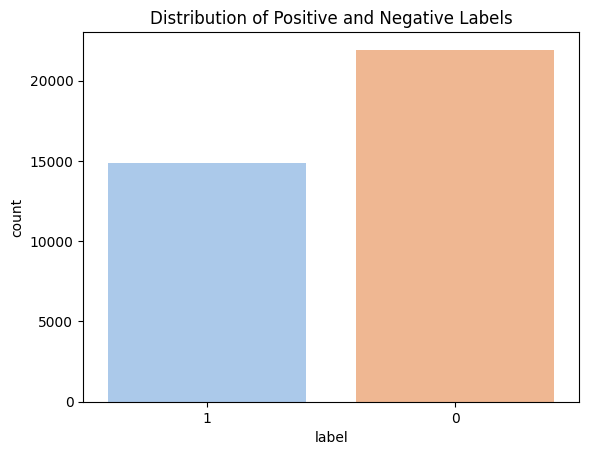

In [6]:
sns.countplot(data =images_df,  x='label',  palette="pastel")
plt.title('Distribution of Positive and Negative Labels')
plt.show()

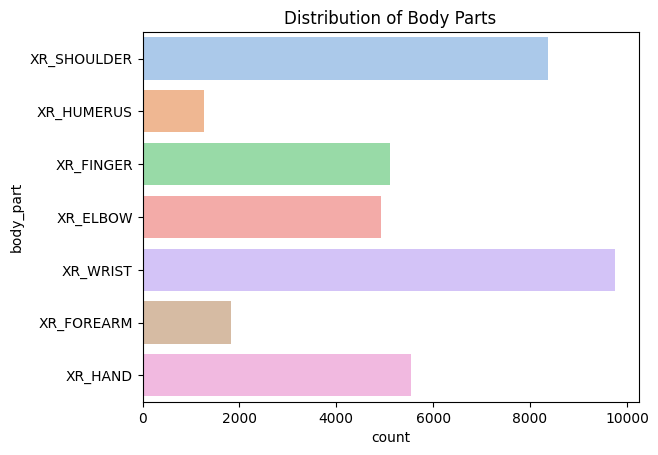

In [7]:
sns.countplot(data= images_df, y='body_part' ,  palette="pastel")
plt.title('Distribution of Body Parts')
plt.show()

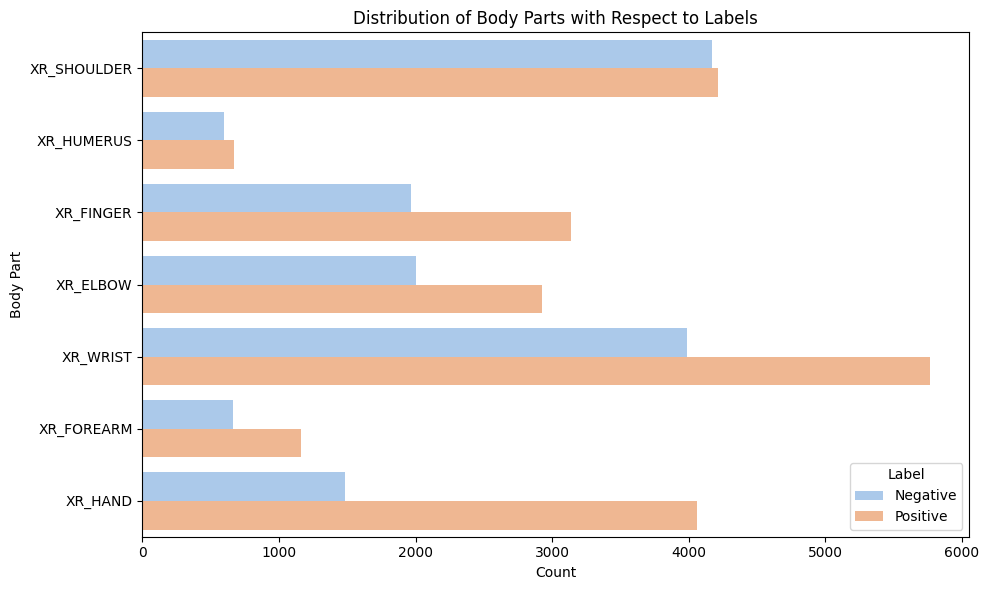

In [8]:
plt.figure(figsize=(10, 6))
sns.countplot(data= images_df , y='body_part', hue='label' ,  palette="pastel")
plt.title('Distribution of Body Parts with Respect to Labels')
plt.ylabel('Body Part')
plt.xlabel('Count')
plt.legend(title='Label', loc='lower right', labels=['Negative', 'Positive'])
plt.tight_layout()
plt.show()

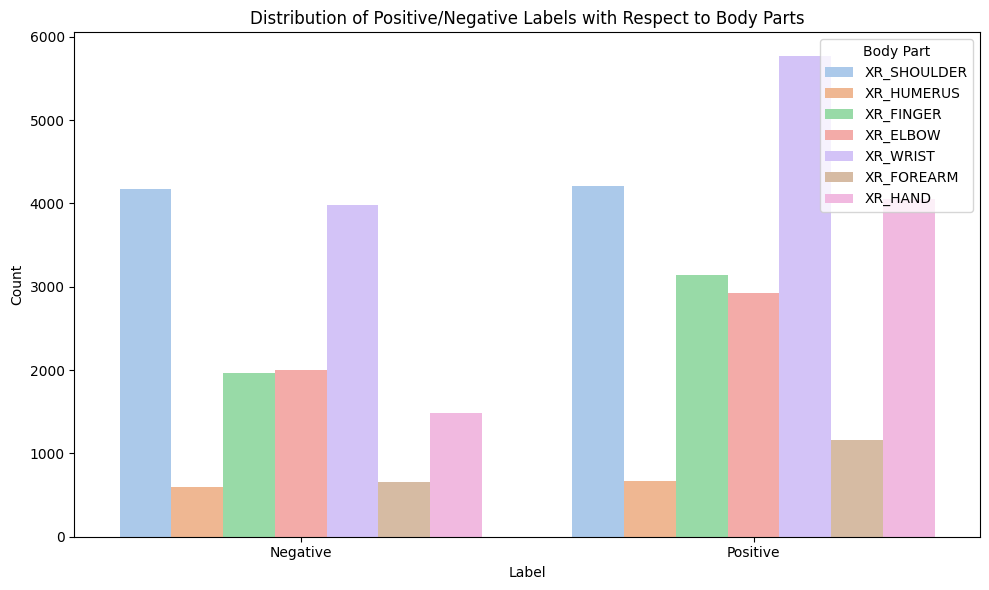

In [9]:
plt.figure(figsize=(10, 6))
sns.countplot(data= images_df , x='label', hue='body_part', palette="pastel")
plt.title('Distribution of Positive/Negative Labels with Respect to Body Parts')
plt.xlabel('Label')
plt.xticks(ticks=[0, 1], labels=['Negative', 'Positive'])
plt.ylabel('Count')
plt.legend(title='Body Part', loc='upper right')
plt.tight_layout()
plt.show()

In [10]:
images_df['patient_id'] = images_df['paths'].str.extract('patient(\d+)')
patient_image_counts = images_df['patient_id'].value_counts()
print(f"Average number of images per patient: {patient_image_counts.mean()}")

Average number of images per patient: 3.2911301859799713


In [11]:
images_df['label_index']= images_df.body_part

In [12]:
images_df.body_part.unique()

array(['XR_SHOULDER', 'XR_HUMERUS', 'XR_FINGER', 'XR_ELBOW', 'XR_WRIST',
       'XR_FOREARM', 'XR_HAND'], dtype=object)

In [13]:
images_df.label_index.replace('XR_SHOULDER', 6, inplace=True)
images_df.label_index.replace('XR_HUMERUS', 5, inplace=True)
images_df.label_index.replace('XR_FINGER', 4, inplace=True)
images_df.label_index.replace('XR_ELBOW', 3, inplace=True)
images_df.label_index.replace('XR_WRIST', 2, inplace=True)
images_df.label_index.replace('XR_FOREARM', 1, inplace=True)
images_df.label_index.replace('XR_HAND', 0, inplace=True)

In [14]:
len(images_df)

36808

In [15]:
images_df.head()

,paths,label,body_part,patient_id,label_index
0,/content/drive/My Drive/Project/MURA-v1.1/trai...,1,XR_SHOULDER,00001,6
1,/content/drive/My Drive/Project/MURA-v1.1/trai...,1,XR_SHOULDER,00001,6
2,/content/drive/My Drive/Project/MURA-v1.1/trai...,1,XR_SHOULDER,00001,6
3,/content/drive/My Drive/Project/MURA-v1.1/trai...,1,XR_SHOULDER,00002,6
4,/content/drive/My Drive/Project/MURA-v1.1/trai...,1,XR_SHOULDER,00002,6


#EDA Validation set

In [16]:
# Create 'label' column
#defining base path
base_path = "/content/drive/My Drive/Project/MURA-v1.1"
#construct the file path to the CSV file named "train_image_paths.csv" by joining the base_path and the CSV file's name using the os.path.join
image_csv_path = os.path.join(base_path, "valid_image_paths.csv")
#will read the above csv file and save in the data frame with column name paths
images_df2 = pd.read_csv(image_csv_path, names=['paths'])
#create complete file paths for each X-ray image.
images_df2["paths"] = "/content/drive/My Drive/Project/" + images_df2["paths"]
#create new column label in the dataframe  will indicate +ve or -ve
# If a path contains the word 'positive,' it is assigned a label of 1 (abnormal), and if not, it's assigned a label of 0 (normal).
images_df2['label'] = images_df2['paths'].str.contains('positive').astype(int)
# It extracts the seventh element (index 7) of each path after splitting the path using '/'
images_df2['body_part'] = images_df2['paths'].str.split('/').str[7]
#  'label' column was initially created as integers (0 or 1), it is now converted to strings.
images_df2['label'] = images_df2['label'].astype(str)

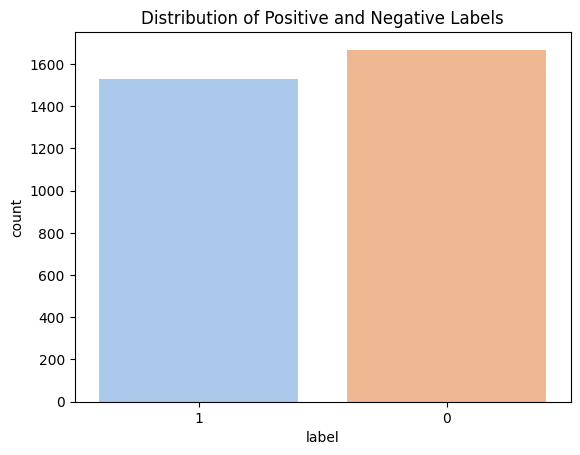

In [17]:
sns.countplot(data =images_df2,  x='label',  palette="pastel")
plt.title('Distribution of Positive and Negative Labels')
plt.show()

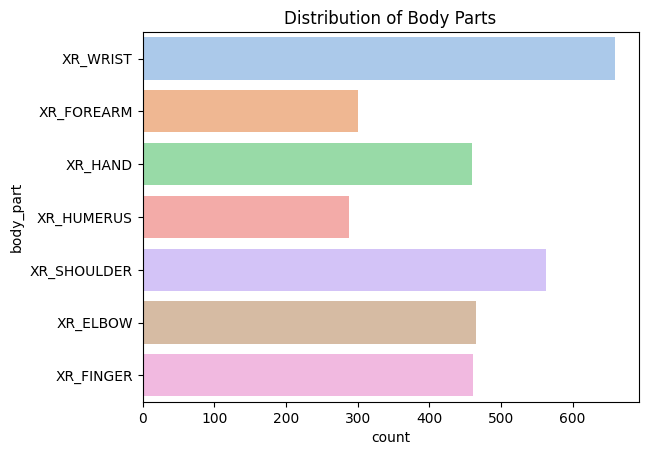

In [18]:
sns.countplot(data= images_df2, y='body_part' ,  palette="pastel")
plt.title('Distribution of Body Parts')
plt.show()

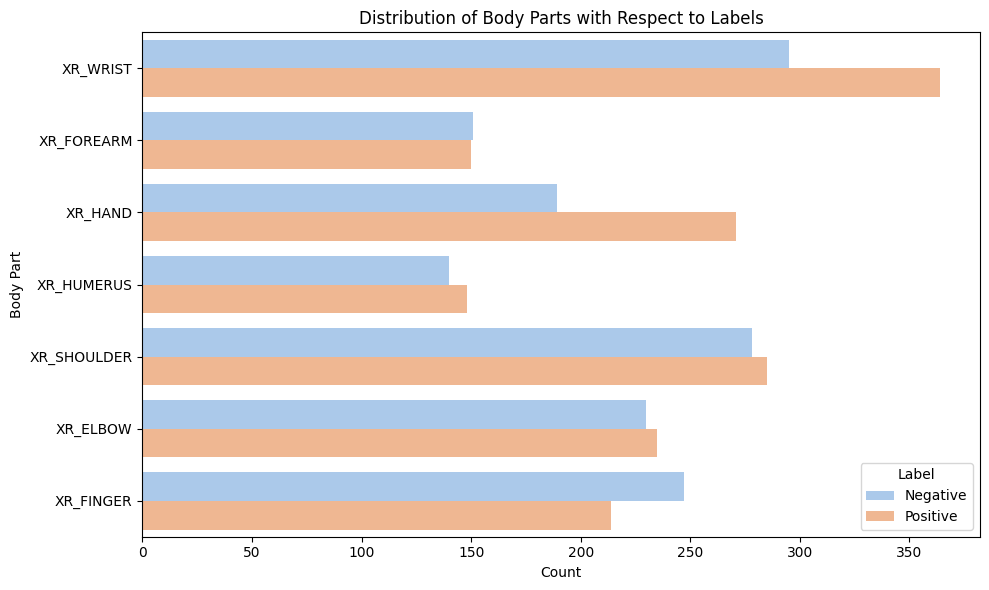

In [19]:
plt.figure(figsize=(10, 6))
sns.countplot(data= images_df2 , y='body_part', hue='label' ,  palette="pastel")
plt.title('Distribution of Body Parts with Respect to Labels')
plt.ylabel('Body Part')
plt.xlabel('Count')
plt.legend(title='Label', loc='lower right', labels=['Negative', 'Positive'])
plt.tight_layout()
plt.show()

In [20]:
images_df2['patient_id'] = images_df2['paths'].str.extract('patient(\d+)')
patient_image_counts = images_df2['patient_id'].value_counts()
print(f"Average number of images per patient: {patient_image_counts.mean()}")

Average number of images per patient: 4.08301404853129


In [21]:
images_df2['label_index']= images_df2.body_part

In [22]:
images_df2.body_part.unique()

array(['XR_WRIST', 'XR_FOREARM', 'XR_HAND', 'XR_HUMERUS', 'XR_SHOULDER',
       'XR_ELBOW', 'XR_FINGER'], dtype=object)

In [23]:
images_df2.label_index.replace('XR_SHOULDER', 6, inplace=True)
images_df2.label_index.replace('XR_HUMERUS', 5, inplace=True)
images_df2.label_index.replace('XR_FINGER', 4, inplace=True)
images_df2.label_index.replace('XR_ELBOW', 3, inplace=True)
images_df2.label_index.replace('XR_WRIST', 2, inplace=True)
images_df2.label_index.replace('XR_FOREARM', 1, inplace=True)
images_df2.label_index.replace('XR_HAND', 0, inplace=True)

In [24]:
len(images_df2)

3197

In [25]:
images_df.head()

,paths,label,body_part,patient_id,label_index
0,/content/drive/My Drive/Project/MURA-v1.1/trai...,1,XR_SHOULDER,00001,6
1,/content/drive/My Drive/Project/MURA-v1.1/trai...,1,XR_SHOULDER,00001,6
2,/content/drive/My Drive/Project/MURA-v1.1/trai...,1,XR_SHOULDER,00001,6
3,/content/drive/My Drive/Project/MURA-v1.1/trai...,1,XR_SHOULDER,00002,6
4,/content/drive/My Drive/Project/MURA-v1.1/trai...,1,XR_SHOULDER,00002,6


#data preprocessing without augmentation

In [26]:
batch_size = 64
image_size = (224, 224)

# Create a data generator without data augmentation
datagen = ImageDataGenerator()


In [27]:
train_gen = datagen.flow_from_dataframe(
    images_df,
    directory=None,
    x_col="paths",
    y_col="body_part",
    subset="training",
    batch_size=batch_size,
    seed=42,
    shuffle=True,
    class_mode='categorical',
    target_size=image_size
)
# It takes care of data loading, resizing, which is crucial for training robust models

Found 36808 validated image filenames belonging to 7 classes.


In [28]:
test_gen = datagen.flow_from_dataframe(
    images_df2,
    directory=None,
    x_col="paths",
    y_col="body_part",
    subset="training",
    batch_size=batch_size,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=image_size
)

Found 3197 validated image filenames belonging to 7 classes.
